# Business Problem:

## Background

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

Source: https://www.hopkinsmedicine.org/health/conditions-and-diseases/pneumonia

## Problem Statement

We need to be able to quickly and accurately identify which patients have pneumonia using a model, so that doctors themselves spend less time reviewing images.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image

# Data Exploration

## Data Load

In [2]:
# Define function for reading images and labelling
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_data('Data/chest_xray/train')
test = get_data('Data/chest_xray/test')
val = get_data('Data/chest_xray/val')

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-2-13bdc3ca8d37>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-k95y01np/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data Fields

/Users/paulvithayathil/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

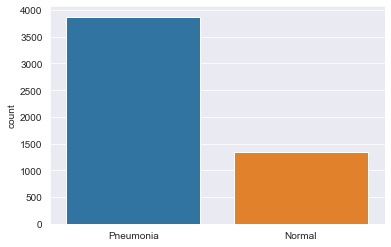

In [4]:
#Countplot of image classification groups
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

- Data is imbalanced

Text(0.5, 1.0, 'NORMAL')

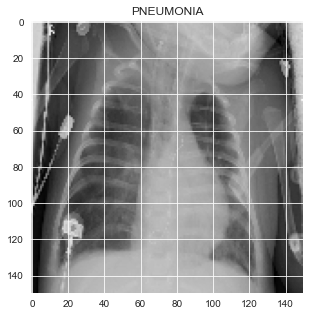

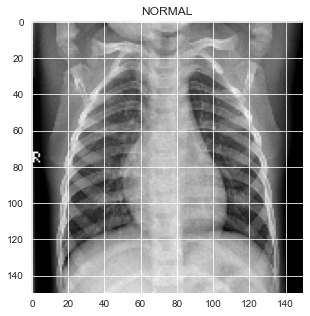

In [5]:
# Print examples of each image classification group
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Data Preparation

## Normalize

Each RGB pixel in an image takes a value between 0 and 255. In Deep Learning, it is very common to standardize and/or center your dataset. For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. 

In [7]:
# Normalize the data - grayscale normalization to reduce illumination differences
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

## Resize

In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation

To avoid overfitting we should artificially expand our data. We will alter the training data with small transformations to reproduce variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. 

Augmentations: grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and more. We will apply a couple of these transformations to our training data, to increase the number of training examples.

In [9]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

# Model Development

2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.

When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers or None, does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in data_format="channels_last". You can use None when a dimension has variable size.

Padding - amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero.

SAME Padding: it applies padding to the input image so that the input image gets fully covered by the filter and specified stride.It is called SAME because, for stride 1 , the output will be the same as the input.

Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video. For example, if a neural network's stride is set to 1, the filter will move one pixel, or unit, at a time.

In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs. 

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

In [10]:
#Build a Sequential Model
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [11]:
#Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
# monitor: quantity to be monitored.
# factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
# patience: number of epochs with no improvement after which learning rate will be reduced.
# verbose: int. 0: quiet, 1: update messages.
# min_lr: lower bound on the learning rate.

In [12]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 111s 673ms/step - loss: 1.0995 - accuracy: 0.8101 - val_loss: 27.8096 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 108s 663ms/step - loss: 0.2605 - accuracy: 0.8963 - val_loss: 52.8648 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 109s 669ms/step - loss: 0.2333 - accuracy: 0.9184 - val_loss: 7.7575 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 107s 654ms/step - loss: 0.1721 - accuracy: 0.9365 - val_loss: 6.3757 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 107s 656ms/step - loss: 0.1377 - accuracy: 0.9492 - val_loss: 57.3085 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
163/163 [==============================] - 108s 661ms/step - loss: 0.1208 - accuracy: 0.9571 -

In [13]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 200ms/step - loss: 1.1711 - accuracy: 0.8702
Loss of the model is -  1.171120047569275
20/20 [==============================] - 4s 204ms/step - loss: 1.1711 - accuracy: 0.8702
Accuracy of the model is -  87.0192289352417 %


loss function is used to measure the inconsistency between the predicted value  (𝑦̂ )  and the actual label  𝑦 .

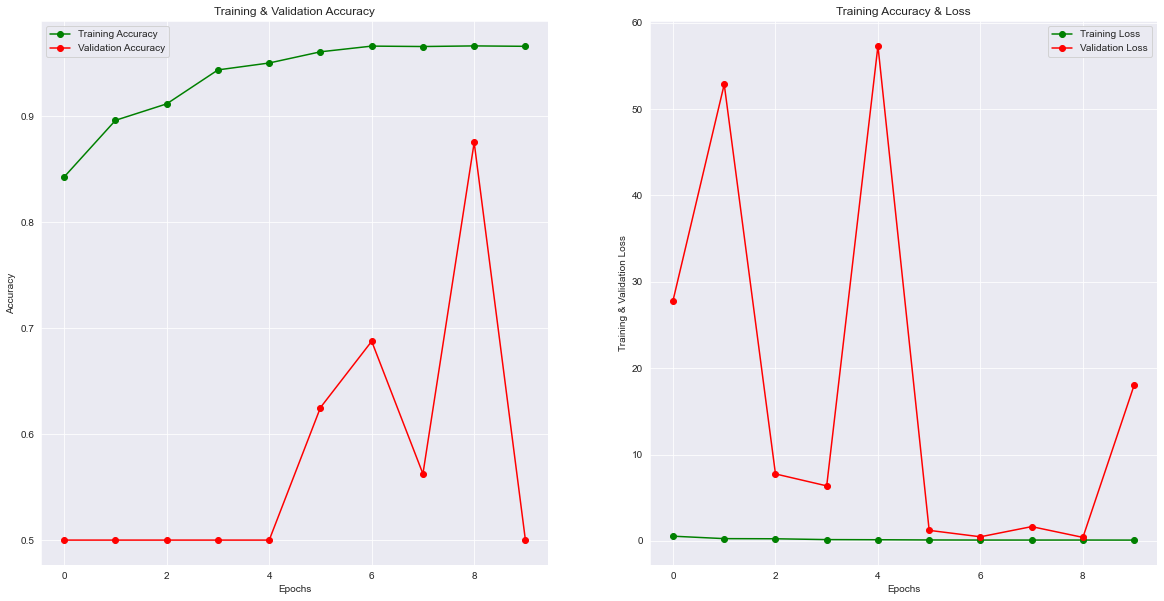

In [34]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [15]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

/Users/paulvithayathil/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [16]:

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.98      0.90       390
   Normal (Class 1)       0.95      0.69      0.80       234

           accuracy                           0.87       624
          macro avg       0.89      0.83      0.85       624
       weighted avg       0.88      0.87      0.86       624



Accuracy is 87% when run with 12 epochs we reach 93%

In [17]:
cm = confusion_matrix(y_test,predictions)
cm

array([[381,   9],
       [ 72, 162]])

In [18]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

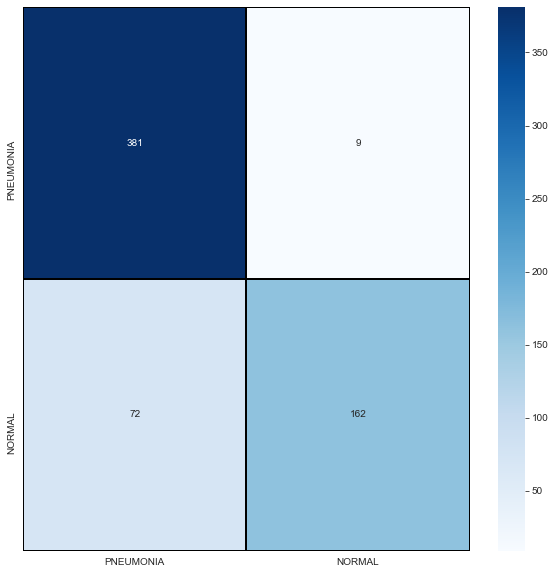

In [19]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [20]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

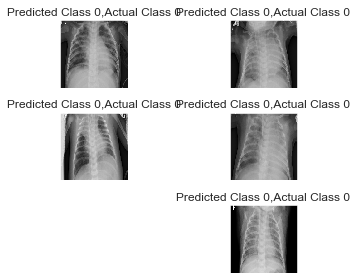

In [21]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

Above are examples of the correctly predicted classes

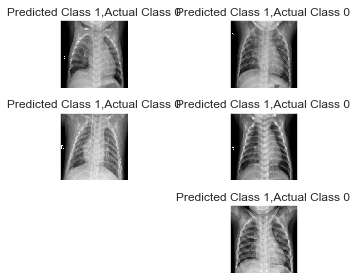

In [22]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1


In [ ]:
Above are examples of the incorrectly predicted Classes

# Conclusions

Our model performed decently but not at the level necessary for medical accuracy
Accuracy is 87% when run with 12 epochs we reach 93%

# Recommendations

Utilize the model for corroboration of physician assessment of x-ray images
Wait until future work is completed to use a model as a primary classification technique

# Future Work

Incorporate transfer learning 
 if a model is trained on a large and general enough dataset, this model will effectively serve as a model of the visual world.
